In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

In [11]:
data = pd.read_csv('Onion.csv')

In [12]:
#Drop na's.
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)

,date,centre_name,commodity_name,price
0,2001-01-01,DELHI,Onion,8.0
1,2001-01-01,MUMBAI,Onion,9.0
2,2001-01-01,KOLKATA,Onion,9.0
3,2001-01-02,DELHI,Onion,9.0
4,2001-01-02,MUMBAI,Onion,8.5
...,...,...,...,...
5078,2015-12-11,MUMBAI,Onion,17.0
5079,2015-12-11,KOLKATA,Onion,16.0
5080,2015-12-14,DELHI,Onion,28.0
5081,2015-12-14,MUMBAI,Onion,30.0


In [13]:
#calculate average price for each centre for each day 
data_gp = data.sort_values('date').groupby(['centre_name', 'date'], as_index=False)
data_gp = data_gp.agg({'price':['mean']})
data_gp.columns = ['centre_name', 'date', 'price']
data_gp.head()

,centre_name,date,price
0,DELHI,2001-01-01,8.0
1,DELHI,2001-01-02,9.0
2,DELHI,2001-01-03,6.5
3,DELHI,2001-01-04,13.0
4,DELHI,2001-01-08,10.0


In [14]:
#centre_1_train_dataset
centre_1_data = data_gp.loc[(data_gp['centre_name']=="DELHI"),["price"]].values
centre_1_data = centre_1_data.astype("float32")

#centre_2_train_dataset
centre_2_data = data_gp.loc[(data_gp['centre_name']=="KOLKATA"),["price"]].values
centre_2_data = centre_2_data.astype("float32")

#centre_2_train_dataset
centre_3_data = data_gp.loc[(data_gp['centre_name']=="MUMBAI"),["price"]].values
centre_3_data = centre_3_data.astype("float32")

print(centre_1_data.size,centre_2_data.size,centre_3_data.size)

1708 1679 1696


In [15]:
#take last year as test dataset
train_centre_1 = centre_1_data[:-365]
test_centre_1 = centre_1_data[-365:]

train_centre_2 = centre_2_data[:-365]
test_centre_2 = centre_2_data[-365:]

train_centre_3 = centre_3_data[:-365]
test_centre_3 = centre_3_data[-365:]

print("train size: {}, test size: {}".format(len(train_centre_1), len(test_centre_1)))

train size: 1343, test size: 365


In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#transform the data using minmax scaler
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_3 = MinMaxScaler(feature_range=(0,1))

train_centre_1 = scaler.fit_transform(train_centre_1)
test_centre_1 = scaler.transform(test_centre_1)

train_centre_2 = scaler_2.fit_transform(train_centre_2)
test_centre_2 = scaler_2.transform(test_centre_2)

train_centre_3 = scaler_3.fit_transform(train_centre_3)
test_centre_3 = scaler_3.transform(test_centre_3)

In [17]:
#train:

time_step = 30
datax_centre_1=[]
datay_centre_1=[]

for i in range(len(train_centre_1)-time_step-1):
    datax_centre_1.append(train_centre_1[i:(i+time_step),0])
    datay_centre_1.append(train_centre_1[i+time_step,0])
trainx_centre_1=np.array(datax_centre_1)
trainy_centre_1=np.array(datay_centre_1)

datax_centre_2=[]
datay_centre_2=[]

for i in range(len(train_centre_2)-time_step-1):
    datax_centre_2.append(train_centre_2[i:(i+time_step),0])
    datay_centre_2.append(train_centre_2[i+time_step,0])
trainx_centre_2=np.array(datax_centre_2)
trainy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(train_centre_3)-time_step-1):
    datax_centre_3.append(train_centre_3[i:(i+time_step),0])
    datay_centre_3.append(train_centre_3[i+time_step,0])
trainx_centre_3=np.array(datax_centre_3)
trainy_centre_3=np.array(datay_centre_3)

In [18]:
#test:

datax_centre_1=[]
datay_centre_1=[]

for i in range(len(test_centre_1)-time_step-1):
    datax_centre_1.append(test_centre_1[i:(i+time_step),0])
    datay_centre_1.append(test_centre_1[i+time_step,0])
testx_centre_1=np.array(datax_centre_1)
testy_centre_1=np.array(datay_centre_1)


datax_centre_2=[]
datay_centre_2=[]

for i in range(len(test_centre_2)-time_step-1):
    datax_centre_2.append(test_centre_2[i:(i+time_step),0])
    datay_centre_2.append(test_centre_2[i+time_step,0])
testx_centre_2=np.array(datax_centre_2)
testy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(test_centre_3)-time_step-1):
    datax_centre_3.append(test_centre_3[i:(i+time_step),0])
    datay_centre_3.append(test_centre_3[i+time_step,0])
testx_centre_3=np.array(datax_centre_3)
testy_centre_3=np.array(datay_centre_3)

In [19]:
trainx_centre_1=np.reshape(trainx_centre_1, (trainx_centre_1.shape[0],1,trainx_centre_1.shape[1]))
testx_centre_1=np.reshape(testx_centre_1, (testx_centre_1.shape[0],1,testx_centre_1.shape[1]))

trainx_centre_2=np.reshape(trainx_centre_2, (trainx_centre_2.shape[0],1,trainx_centre_2.shape[1]))
testx_centre_2=np.reshape(testx_centre_2, (testx_centre_2.shape[0],1,testx_centre_2.shape[1]))

trainx_centre_3=np.reshape(trainx_centre_3, (trainx_centre_3.shape[0],1,trainx_centre_3.shape[1]))
testx_centre_3=np.reshape(testx_centre_3, (testx_centre_3.shape[0],1,testx_centre_3.shape[1]))


In [20]:
model =Sequential()
model.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_1 = model.fit(trainx_centre_1, trainy_centre_1, epochs=100, batch_size=32,    validation_split=0.1, shuffle=False)

Epoch 1/100
37/37 [==============================] - 0s 13ms/step - loss: 0.9966 - val_loss: 0.9904
Epoch 2/100
37/37 [==============================] - 0s 3ms/step - loss: 0.8679 - val_loss: 0.8692
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 0.8034 - val_loss: 0.8037
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.7650 - val_loss: 0.7649
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.7376 - val_loss: 0.7396
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.7156 - val_loss: 0.7218
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6967 - val_loss: 0.7085
Epoch 8/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6800 - val_loss: 0.6985
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6650 - val_loss: 0.6907
Epoch 10/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6513 - val_loss: 0.6847
Epoch 11

In [21]:
model_2 =Sequential()
model_2.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
history_2 = model.fit(trainx_centre_2, trainy_centre_2, epochs=100, batch_size=32,   validation_split=0.1, shuffle=False)

Epoch 1/100
37/37 [==============================] - 0s 3ms/step - loss: 0.1247 - val_loss: 0.0544
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0414
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0345
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0301
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0270
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0247
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0231
Epoch 8/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0219
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0209
Epoch 10/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0201
Epoch 11/

In [22]:
model_3 =Sequential()
model_3.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
history_3 = model.fit(trainx_centre_3, trainy_centre_3, epochs=100, batch_size=32,  validation_split=0.1, shuffle=False) 

Epoch 1/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0162
Epoch 2/100
37/37 [==============================] - 0s 3ms/step - loss: 0.0143 - val_loss: 0.0163
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0164
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0165
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0165
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0166
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0166
Epoch 8/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0167
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0167
Epoch 10/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0167
Epoch 11/

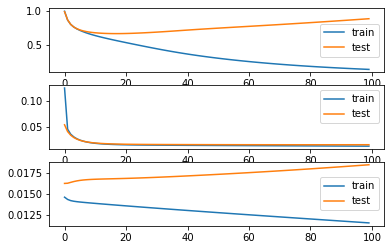

In [23]:
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 2)
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 3)
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend();

In [24]:
trainy_centre_1 = trainy_centre_1.reshape(1,-1)
testy_centre_1 = testy_centre_1.reshape(1,-1)

trainy_centre_2 = trainy_centre_2.reshape(1,-1)
testy_centre_2 = testy_centre_2.reshape(1,-1)

trainy_centre_3 = trainy_centre_3.reshape(1,-1)
testy_centre_3 = testy_centre_3.reshape(1,-1)

In [25]:
testPredict_centre_1 = model.predict(testx_centre_1)
testPredict_centre_1 = scaler.inverse_transform(testPredict_centre_1)
testy_centre_1 = scaler.inverse_transform(testy_centre_1)
trainPredict_centre_1 = model.predict(trainx_centre_1)
trainPredict_centre_1 = scaler.inverse_transform(trainx_centre_1)
trainy_centre_1 = scaler.inverse_transform(trainy_centre_1)

testPredict_centre_2 = model.predict(testx_centre_2)
trainPredict_centre_2 = model.predict(trainx_centre_2)
trainPredict_centre_2 = scaler.inverse_transform(trainx_centre_2)
testPredict_centre_2 = scaler.inverse_transform(testPredict_centre_2)
testy_centre_2 = scaler.inverse_transform(testy_centre_2)
trainy_centre_2 = scaler.inverse_transform(trainy_centre_2)

testPredict_centre_3 = model.predict(testx_centre_3)
trainPredict_centre_3 = model.predict(trainx_centre_3)
trainPredict_centre_3 = scaler.inverse_transform(trainx_centre_3)
testPredict_centre_3 = scaler.inverse_transform(testPredict_centre_3)
testy_centre_3 = scaler.inverse_transform(testy_centre_3)
trainy_centre_3 = scaler.inverse_transform(trainy_centre_3)

<Figure size 432x288 with 0 Axes>

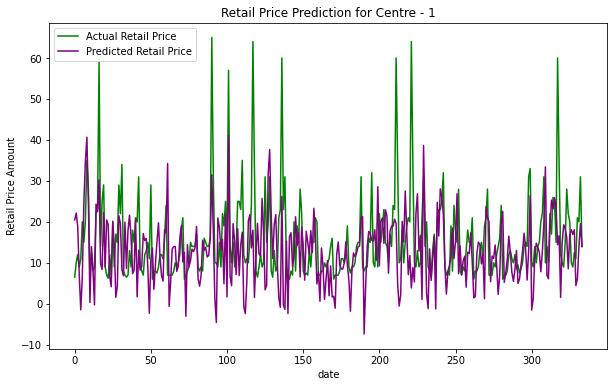

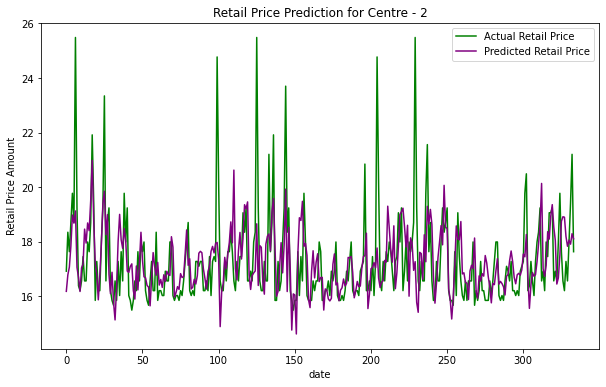

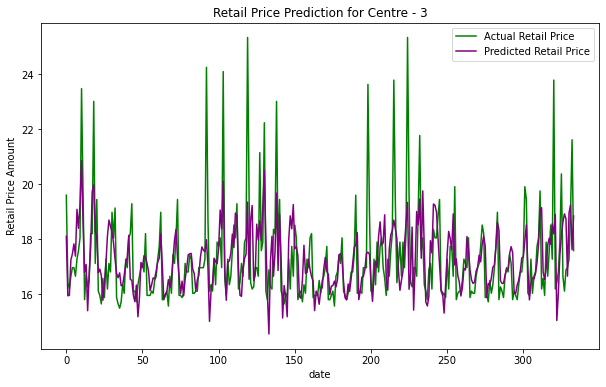

In [26]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(testy_centre_1[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_1 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 1')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_2[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_2 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 2')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_3[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_3 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 3')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

In [27]:
# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE: {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE for centre 1 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_2[0], trainPredict_centre_2[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_2[0], testPredict_centre_2[:,0]))
# print("Train MSE for centre 2 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_3[0], trainPredict_centre_3[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_3[0], testPredict_centre_3[:,0]))
# print("Train MSE for centre 3 model : {}, Test MSE: {}".format(trainscore, testscore))

In [28]:
print(trainy_centre_2[0], trainPredict_centre_2[:,0])

[15.85269  16.209475 16.923046 ... 17.101439 17.27983  17.27983 ] [[16.387867 16.209475 15.85269  ... 15.85269  15.763494 16.209475]
 [16.209475 15.85269  16.56626  ... 15.763494 16.209475 15.85269 ]
 [15.85269  16.56626  16.56626  ... 16.209475 15.85269  16.209475]
 ...
 [15.674297 15.674297 16.56626  ... 16.209475 16.031082 17.27983 ]
 [15.674297 16.56626  16.209475 ... 16.031082 17.27983  17.101439]
 [16.56626  16.209475 16.56626  ... 17.27983  17.101439 17.27983 ]]


# Predicting 90 days of 2015

In [29]:
#use retail price of last 30 days of 2014 to predict next 90 days

#centre-1
testPredict_centre_1 = []

x_data_centre_1 = testx_centre_1[-1] #get transformed retail price values of last 30 days 
x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
yhat = model.predict(x_centre_1)
testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
x_data_centre_1 = np.append(x_data_centre_1,yhat)

for i in range (89):
        x_data_centre_1 = x_data_centre_1[1:]
        x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
        yhat = model.predict(x_centre_1)
        testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
        x_data_centre_1 = np.append(x_data_centre_1,yhat)
        
#centre-2     
testPredict_centre_2 = []

x_data_centre_2 = testx_centre_2[-1] #get transformed retail price values of last 30 days 
x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
yhat = model.predict(x_centre_2)
testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
x_data_centre_2 = np.append(x_data_centre_2,yhat)

for i in range (89):
        x_data_centre_2 = x_data_centre_2[1:]
        x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
        yhat = model.predict(x_centre_2)
        testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
        x_data_centre_2 = np.append(x_data_centre_2,yhat)
        
#centre-3
testPredict_centre_3 = []

x_data_centre_3 = testx_centre_3[-1] #get transformed retail price values of last 30 days 
x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
yhat = model.predict(x_centre_3)
testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
x_data_centre_3 = np.append(x_data_centre_3,yhat)

for i in range (89):
        x_data_centre_3 = x_data_centre_3[1:]
        x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
        yhat = model.predict(x_centre_3)
        testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
        x_data_centre_3 = np.append(x_data_centre_3,yhat)
        


In [30]:
#Create Dataframe with predicted retail prices
centre_1_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_1_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_1_test_df['centre_name'] = "DELHI"
centre_1_test_df['commodity_name'] = "Onion"
centre_1_test_df['predicted_retail_price'] = testPredict_centre_1

#Create Dataframe with predicted retail prices
centre_2_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_2_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_2_test_df['centre_name'] = "KOLKATA"
centre_2_test_df['commodity_name'] = "Onion"
centre_2_test_df['predicted_retail_price'] = testPredict_centre_2

#Create Dataframe with predicted retail prices
centre_3_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_3_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_3_test_df['centre_name'] = "MUMBAI"
centre_3_test_df['commodity_name'] = "Onion"
centre_3_test_df['predicted_retail_price'] = testPredict_centre_3

test_df = pd.concat([centre_1_test_df , centre_2_test_df, centre_3_test_df],ignore_index=True)
test_df

,date,centre_name,commodity_name,predicted_retail_price
0,2015-01-01,DELHI,Onion,13.960816
1,2015-01-02,DELHI,Onion,17.667334
2,2015-01-03,DELHI,Onion,29.951460
3,2015-01-04,DELHI,Onion,33.515171
4,2015-01-05,DELHI,Onion,18.307400
...,...,...,...,...
265,2015-03-27,MUMBAI,Onion,18.368925
266,2015-03-28,MUMBAI,Onion,17.397865
267,2015-03-29,MUMBAI,Onion,16.964737
268,2015-03-30,MUMBAI,Onion,17.171204


In [31]:
test_df.to_csv('lstm_price_prediction_onion.csv',index=False)